In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic_sources.csv', header=0)

icegrav_coords = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
coordinates = [icegrav_synthetic.x, icegrav_synthetic.y, icegrav_synthetic.u]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

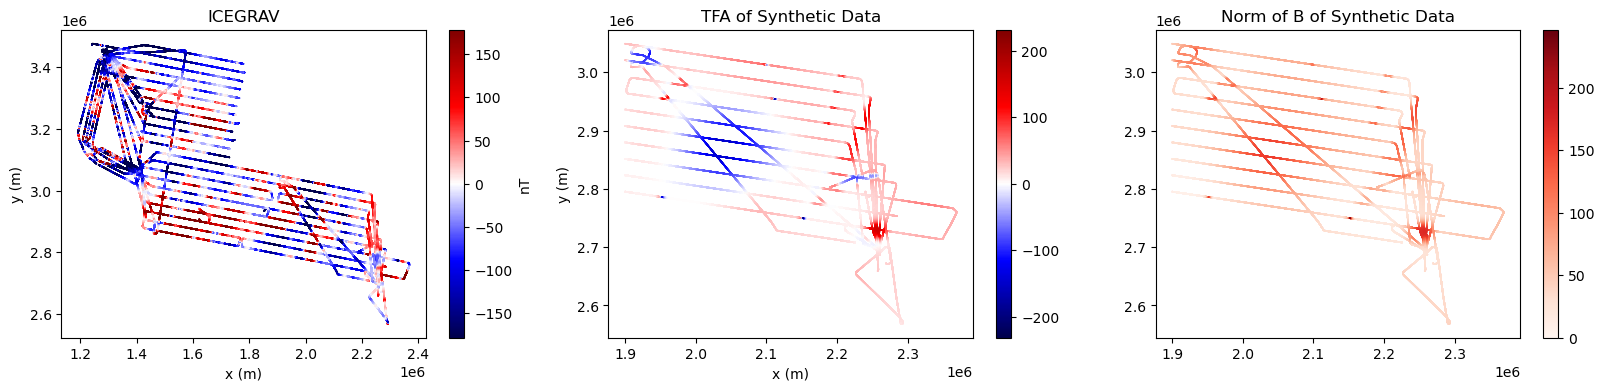

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
scale_tfa_real = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*icegrav_coords[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale_tfa_real, vmax=scale_tfa_real)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale_tfa_synthetic = vd.maxabs(icegrav_synthetic.tfa)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa, cmap="seismic",s=0.01, vmin=-scale_tfa_synthetic, vmax=scale_tfa_synthetic)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.subplot(1,3,3)
scale_bnorm_synthetic = vd.maxabs(icegrav_synthetic.bnorm)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.bnorm, cmap="Reds",s=0.01, vmin=0, vmax=scale_bnorm_synthetic)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

In [5]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

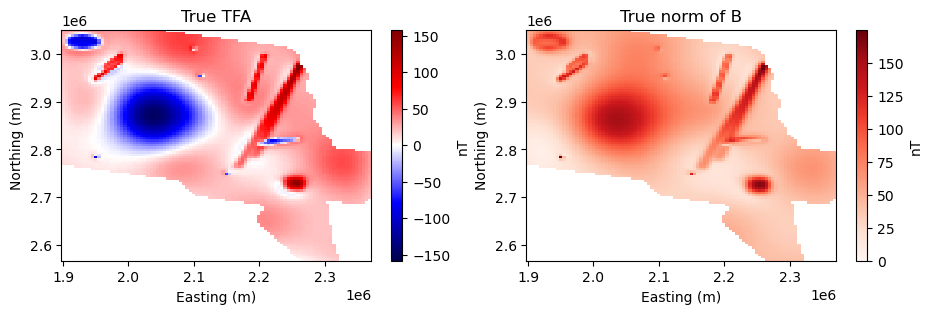

In [6]:
plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
scale_true_tfa = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,2,2)
scale_true_bnorm = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale_true_bnorm)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

# One layer GB EQS

In [7]:
dampings_1layer = [1e1, 1e2, 1e3, 1e4, 1e5]
depths_1layer = [10e3, 20e3, 30e3, 40e3, 50e3]
parameter_sets_1layer = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_1layer, depths_1layer)
]
print("Number of combinations:", len(parameter_sets_1layer))

Number of combinations: 25


In [8]:
%%time
kfold = vd.BlockKFold(
    spacing=50e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_1layer = []
damping_1layer = []
source_depth_1layer = []
for parameters in parameter_sets_1layer:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=grid_spacing, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            icegrav_synthetic.tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(icegrav_synthetic.tfa[test] - predicted))
    scores_1layer.append(np.mean(tmp))
    damping_1layer.append(parameters['damping'])
    source_depth_1layer.append(parameters['depth'])

{'damping': 10.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 20000.0}
{'damping': 10.0, 'depth': 30000.0}
{'damping': 10.0, 'depth': 40000.0}
{'damping': 10.0, 'depth': 50000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 20000.0}
{'damping': 100.0, 'depth': 30000.0}
{'damping': 100.0, 'depth': 40000.0}
{'damping': 100.0, 'depth': 50000.0}
{'damping': 1000.0, 'depth': 10000.0}
{'damping': 1000.0, 'depth': 20000.0}
{'damping': 1000.0, 'depth': 30000.0}
{'damping': 1000.0, 'depth': 40000.0}
{'damping': 1000.0, 'depth': 50000.0}
{'damping': 10000.0, 'depth': 10000.0}
{'damping': 10000.0, 'depth': 20000.0}
{'damping': 10000.0, 'depth': 30000.0}
{'damping': 10000.0, 'depth': 40000.0}
{'damping': 10000.0, 'depth': 50000.0}
{'damping': 100000.0, 'depth': 10000.0}
{'damping': 100000.0, 'depth': 20000.0}
{'damping': 100000.0, 'depth': 30000.0}
{'damping': 100000.0, 'depth': 40000.0}
{'damping': 100000.0, 'depth': 50000.0}
CPU times: user 4h 15min 32s, sys: 1h 29min, total

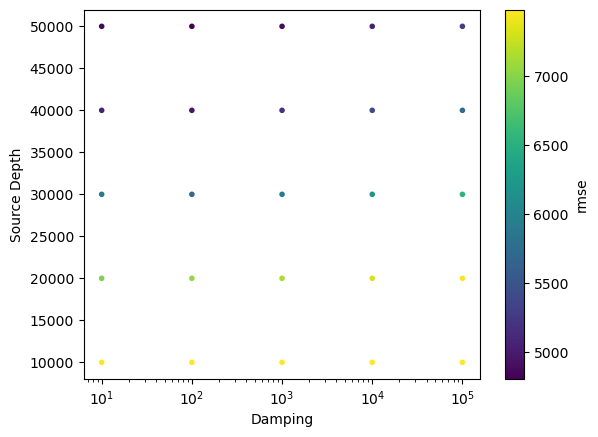

{'damping': 100.0, 'depth': 50000.0}

In [9]:
plt.figure()
plt.scatter(
    damping_1layer,
    source_depth_1layer,
    c=scores_1layer,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_1layer,80),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

best_1layer = np.argmin(scores_1layer)
parameter_sets_1layer[best_1layer]

In [10]:
%%time
eqs_shallow_1layer = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=grid_spacing, **parameter_sets_1layer[best_1layer])
eqs_shallow_1layer.fit(coordinates, icegrav_synthetic.tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -47114.9
window size: 110731.74436429914
CPU times: user 2min 34s, sys: 51.4 s, total: 3min 26s
Wall time: 6.14 s


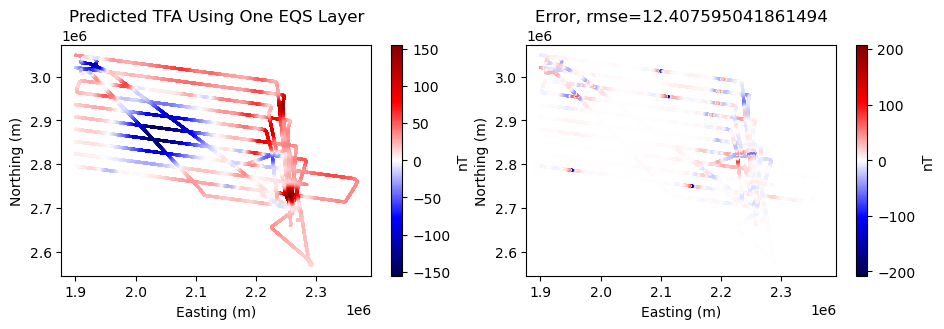

In [11]:
tfa_predicted_1layer = eqs.total_field_anomaly(eqs_shallow_1layer.predict(coordinates), field_direction)

scale_tfa_1layer = vd.maxabs(tfa_predicted_1layer)
plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_predicted_1layer, cmap="seismic", s=1, vmin=-scale_tfa_1layer, vmax=scale_tfa_1layer)
plt.title("Predicted TFA Using One EQS Layer")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

error_tfa_1layer = icegrav_synthetic.tfa - tfa_predicted_1layer
rmse_tfa_1layer = np.sqrt(np.nanmean((error_tfa_1layer)**2))
scale_error_tfa_1layer = vd.maxabs(error_tfa_1layer)
plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=error_tfa_1layer, cmap="seismic", s=1, vmin=-scale_error_tfa_1layer, vmax=scale_error_tfa_1layer)
plt.title('Error, rmse={}'.format(rmse_tfa_1layer))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

### Grid Prediction

In [12]:
predicted_b_grid_1layer = eqs_shallow_1layer.predict(grid_coords_masked)
predicted_tfa_grid_1layer = eqs.total_field_anomaly(predicted_b_grid_1layer, field_direction)
error_tfa_grid_1layer = true_tfa - predicted_tfa_grid_1layer
rmse_tfa_grid_1layer = np.sqrt(np.nanmean((error_tfa_grid_1layer)**2))

predicted_bnorm_grid_1layer = np.sqrt(sum(c**2 for c in predicted_b_grid_1layer))
error_bnorm_grid_1layer = true_bnorm - predicted_bnorm_grid_1layer
rmse_bnorm_grid_1layer = np.sqrt(np.nanmean((error_bnorm_grid_1layer)**2))

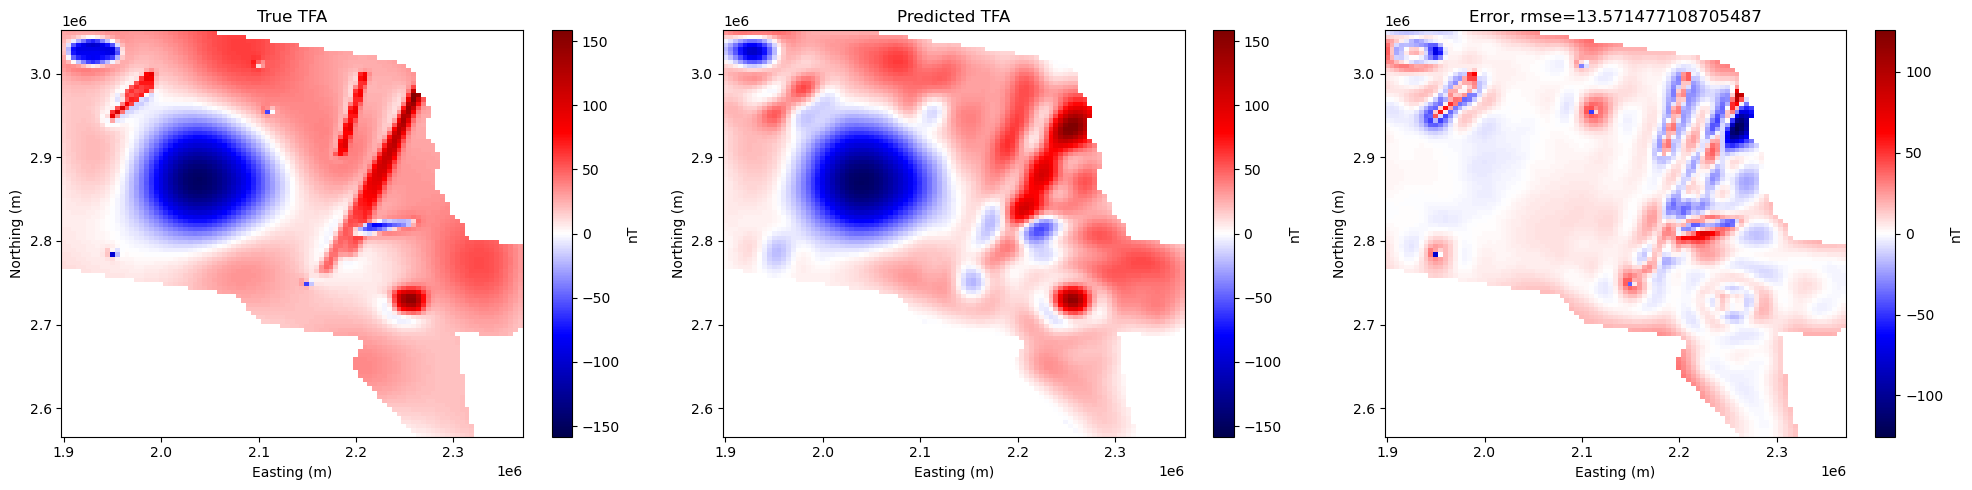

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(
    *grid_coordinates[:2],
    true_tfa, cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(
    *grid_coordinates[:2],
    predicted_tfa_grid_1layer,
    cmap="seismic",
    vmin=-scale_true_tfa,
    vmax=scale_true_tfa,
)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale_error_tfa_grid_1layer = vd.maxabs(error_tfa_grid_1layer)
plt.pcolormesh(
    *grid_coordinates[:2],
    error_tfa_grid_1layer,
    cmap="seismic",
    vmin=-scale_error_tfa_grid_1layer,
    vmax=scale_error_tfa_grid_1layer,
)
plt.title('Error, rmse={}'.format(rmse_tfa_grid_1layer))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

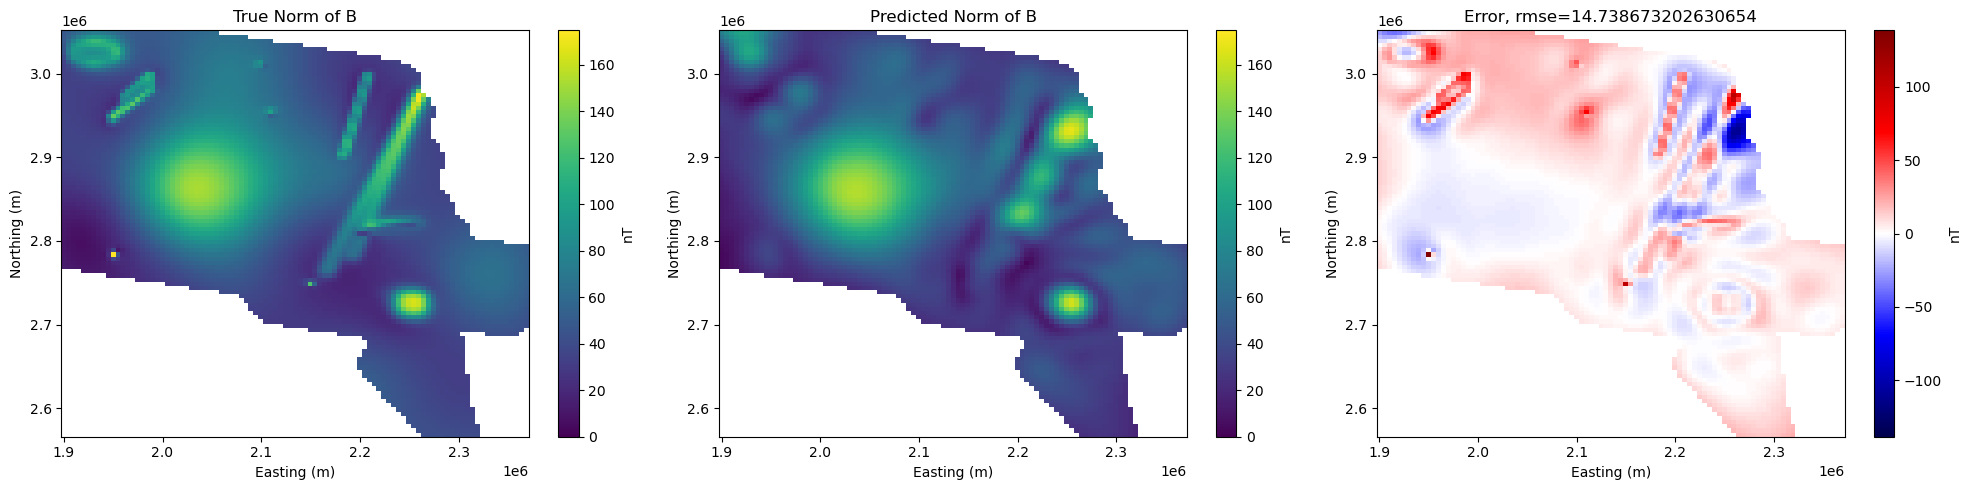

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(
    *grid_coordinates[:2],
    true_bnorm,
    cmap="viridis",
    vmin=0,
    vmax=scale_true_bnorm,
)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(
    *grid_coordinates[:2],
    predicted_bnorm_grid_1layer,
    cmap="viridis",
    vmin=0,
    vmax=scale_true_bnorm,
)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale_error_bnorm_grid_1layer = vd.maxabs(error_bnorm_grid_1layer)
plt.pcolormesh(
    *grid_coordinates[:2],
    error_bnorm_grid_1layer,
    cmap="seismic",
    vmin=-scale_error_bnorm_grid_1layer,
    vmax=scale_error_bnorm_grid_1layer
)
plt.title('Error, rmse={}'.format(rmse_bnorm_grid_1layer))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

# 2 layer EQS

## Fit deep sources

### Block average

In [15]:
block_spacing = 25e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.2)),
    drop_coords=False
)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

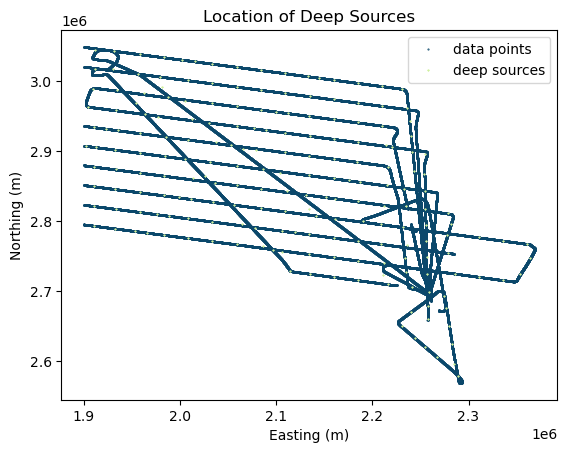

In [16]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], "*", color="#cff09e", markersize=1, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

### Find optimal damping and depth

In [17]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep = [1e-2, 1e-1, 1, 1e1, 1e2]
# depths_deep_eqs = [spacing*3, spacing*3.5, spacing*4]
# dampings_deep_eqs = [1e1, 1e2, 1e3]

In [18]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 40


In [19]:
%%time
kfold = vd.BlockKFold(
    spacing=100e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    # print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 8min 20s, sys: 3min 45s, total: 12min 6s
Wall time: 20.5 s


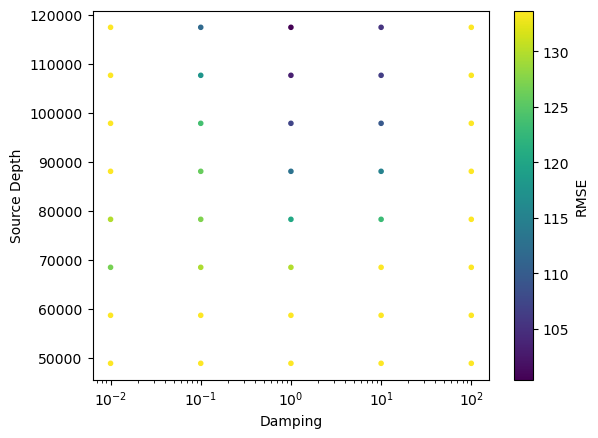

{'damping': 1, 'depth': 117422.42366088359}

In [20]:
plt.figure()
plt.scatter(
    damping_deep,
    source_depth_deep,
    c=scores_deep,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_deep,50),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()
best_deep = np.argmin(scores_deep)
parameter_sets_deep[best_deep]

###  Deep prediction

In [21]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -114537.9736608836
CPU times: user 693 ms, sys: 105 ms, total: 798 ms
Wall time: 23.5 ms


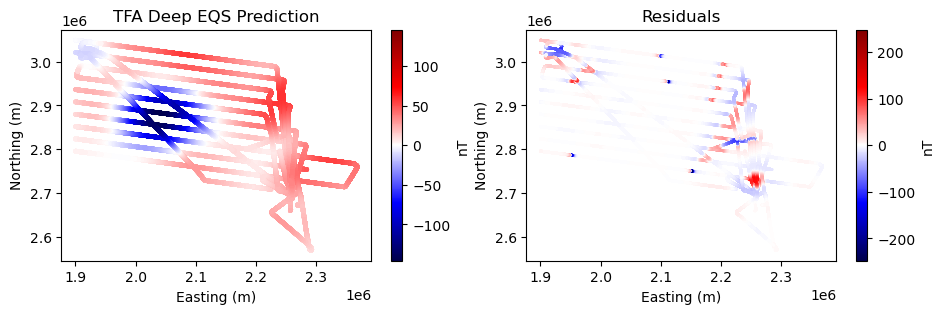

In [22]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

plt.figure(figsize=(11,3))
plt.subplot(1,2,1)
scale_tfa_deep = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale_tfa_deep, vmax=scale_tfa_deep)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale_tfa_residuals = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale_tfa_residuals, vmax=scale_tfa_residuals)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

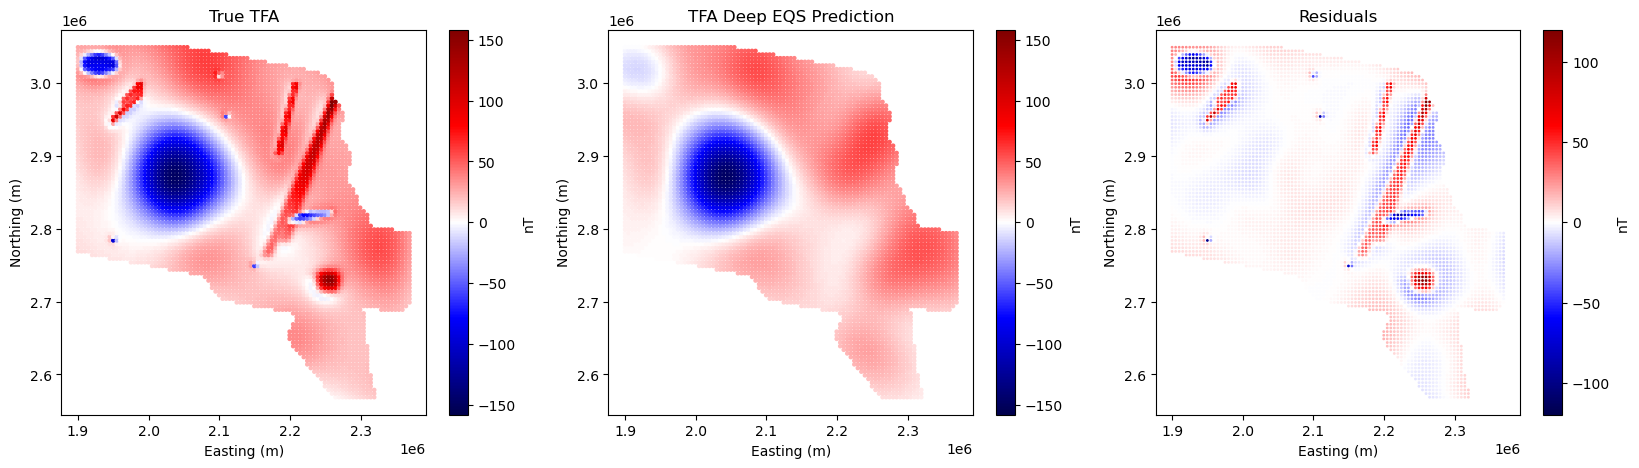

In [23]:
tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa - tfa_deep_grid
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.scatter(*grid_coords_masked[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
# scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale_tfa_residual_grid = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale_tfa_residual_grid, vmax=scale_tfa_residual_grid)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

### Find optimal damping and depth

In [24]:
window_size = 250e3
dampings_shallow = [1e0, 1e1, 1e2]
depths_shallow = [10e3, 11e3, 12e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 25


In [25]:
%%time
kfold = vd.BlockKFold(
    spacing=50e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores_shallow.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 0.01, 'depth': 8000.0}
{'damping': 0.01, 'depth': 9000.0}
{'damping': 0.01, 'depth': 10000.0}
{'damping': 0.01, 'depth': 11000.0}
{'damping': 0.01, 'depth': 12000.0}
{'damping': 0.1, 'depth': 8000.0}
{'damping': 0.1, 'depth': 9000.0}
{'damping': 0.1, 'depth': 10000.0}
{'damping': 0.1, 'depth': 11000.0}
{'damping': 0.1, 'depth': 12000.0}
{'damping': 1.0, 'depth': 8000.0}
{'damping': 1.0, 'depth': 9000.0}
{'damping': 1.0, 'depth': 10000.0}
{'damping': 1.0, 'depth': 11000.0}
{'damping': 1.0, 'depth': 12000.0}
{'damping': 10.0, 'depth': 8000.0}
{'damping': 10.0, 'depth': 9000.0}
{'damping': 10.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 11000.0}
{'damping': 10.0, 'depth': 12000.0}
{'damping': 100.0, 'depth': 8000.0}
{'damping': 100.0, 'depth': 9000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 11000.0}
{'damping': 100.0, 'depth': 12000.0}
CPU times: user 1h 9min 31s, sys: 20min 5s, total: 1h 29min 36s
Wall time: 7min 37s


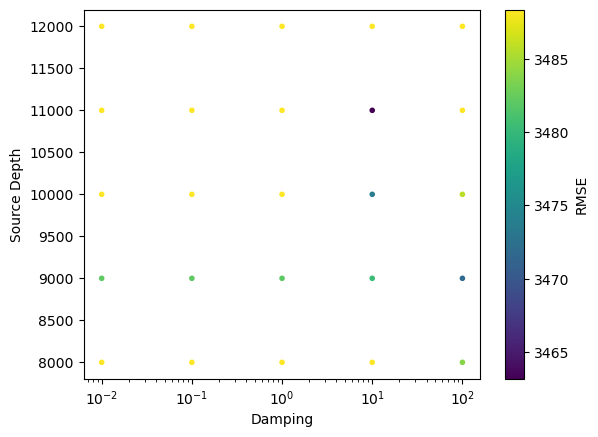

{'damping': 10.0, 'depth': 11000.0}

In [26]:
plt.figure()
plt.scatter(
    damping_shallow,
    source_depth_shallow,
    c=scores_shallow,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores_shallow,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

best_shallow = np.argmin(scores_shallow)
parameter_sets_shallow[best_shallow]

### Find optimal window size

### Shallow Prediction

In [27]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 1min 15s, sys: 17.8 s, total: 1min 32s
Wall time: 10.3 s


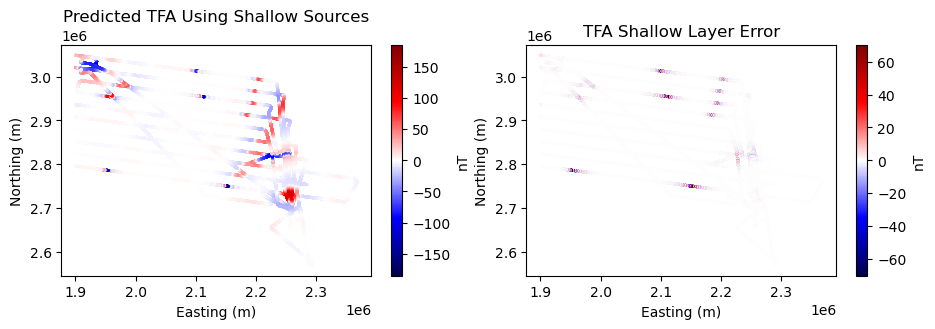

In [28]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(11,3))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted
scale_error_shallow_predicted = vd.maxabs(error_shallow_predicted)
plt.scatter(*coordinates[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_error_shallow_predicted, vmax=scale_error_shallow_predicted)
plt.title("TFA Shallow Layer Error")
plt.xlabel( "Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [29]:
predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
error_tfa_grid = true_tfa - predicted_tfa_grid
rmse_tfa_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))

predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))
error_bnorm_grid = true_bnorm - predicted_bnorm_grid
rmse_bnorm_grid = np.sqrt(np.nanmean((error_tfa_grid)**2))

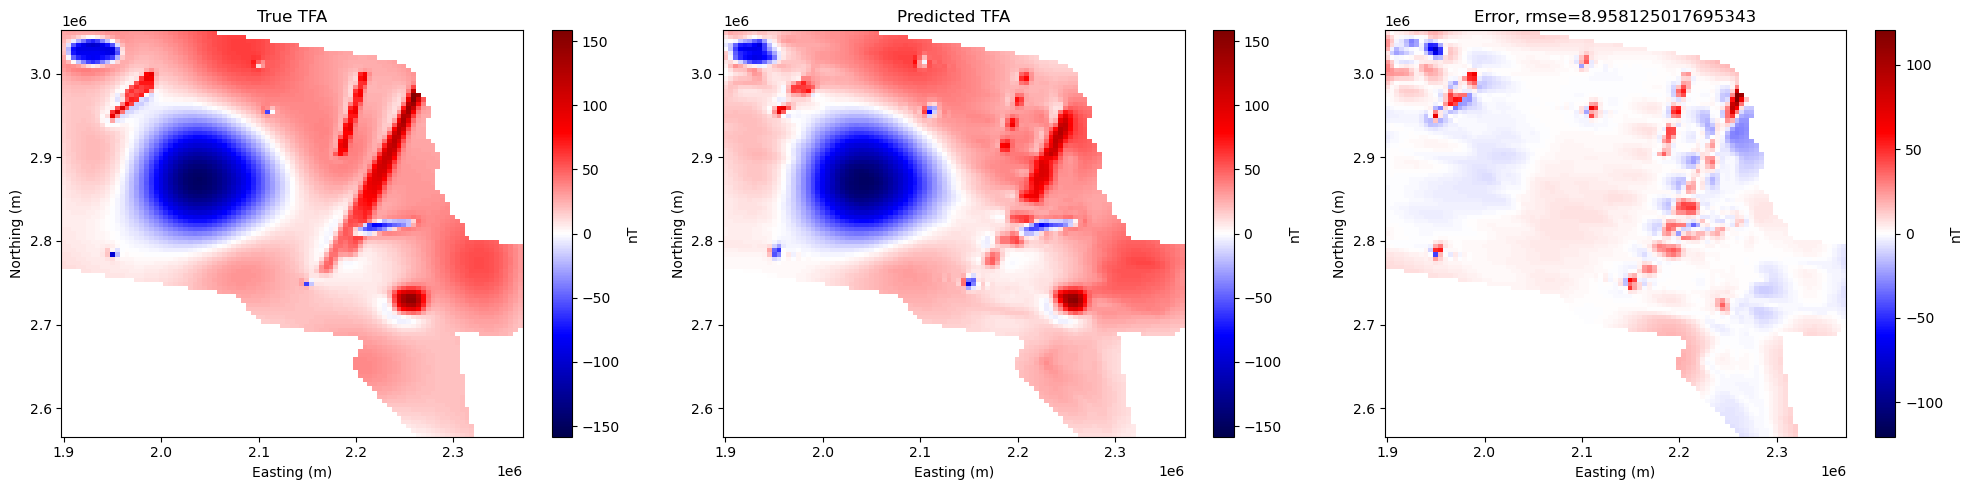

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa_grid, cmap="seismic", vmin=-scale_true_tfa, vmax=scale_true_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale_error_tfa_grid = vd.maxabs(error_tfa_grid)
plt.pcolormesh(*grid_coordinates[:2], error_tfa_grid, cmap="seismic", vmin=-scale_error_tfa_grid, vmax=scale_error_tfa_grid)
plt.title('Error, rmse={}'.format(rmse_tfa_grid))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

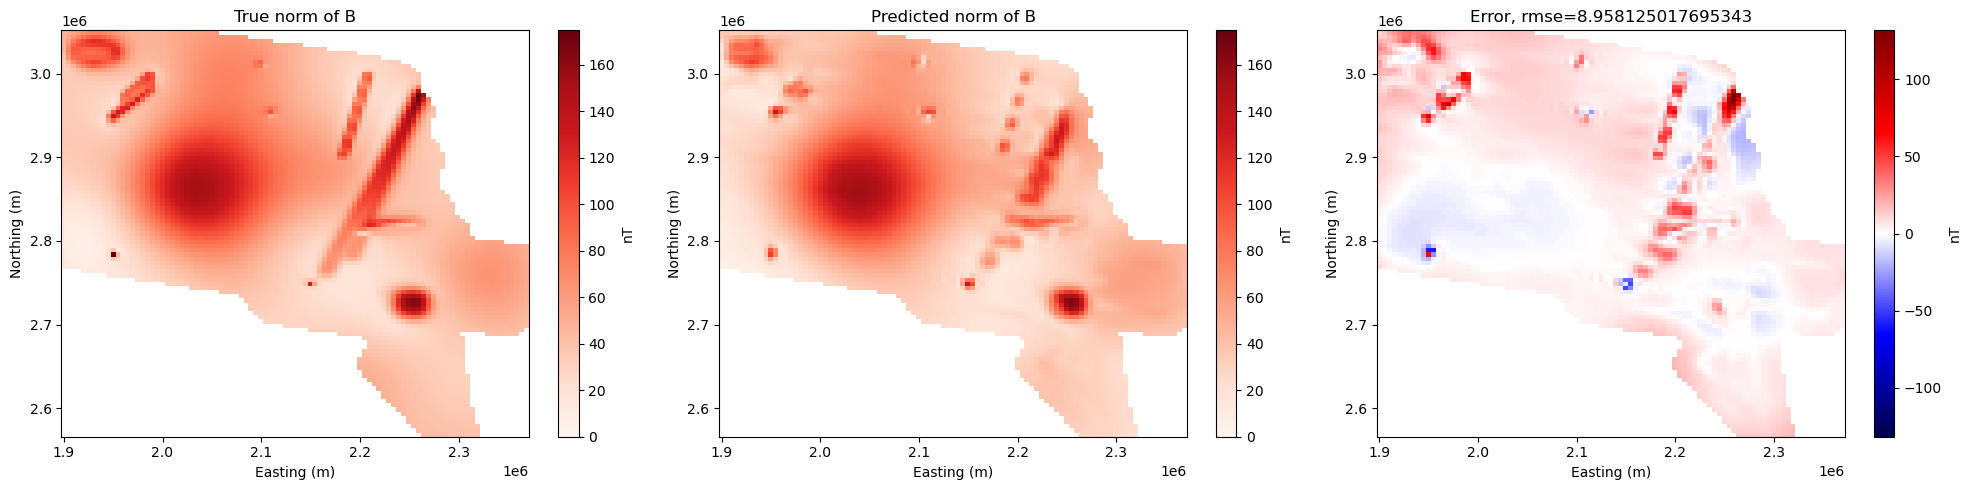

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale_true_bnorm)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_bnorm_grid, cmap="Reds", vmin=0, vmax=scale_true_bnorm)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale_error_bnorm_grid = vd.maxabs(error_bnorm_grid)
plt.pcolormesh(*grid_coordinates[:2], error_bnorm_grid, cmap="seismic", vmin=-scale_error_bnorm_grid, vmax=scale_error_bnorm_grid)
plt.title('Error, rmse={}'.format(rmse_bnorm_grid))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()